In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

## Defining a arbitrary function

In [2]:
def f(x):
    return 3 * x ** 2 - 4 * x + 5

In [3]:
f(3.0)

20.0

### Create an array of range (-5,5) of increment 0.25 & Apply f

In [4]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

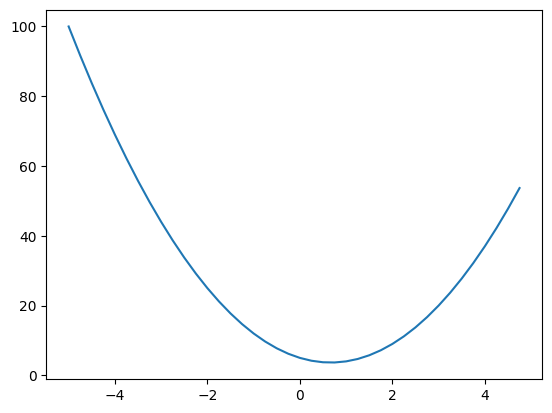

In [6]:
plt.plot(xs, ys)

As the derivative is not usually calculated in neural networks, the below snippet is used as an intuitive explanation of how the slope at a point is found 

In [7]:
h = 0.00000001
x = -3.0
(f(x + h) - f(x))/h

-22.00000039920269

# Multivariate Example

In [8]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [9]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)
# d2 - d1 is how much the function increased by when we bumped the input a
# This is then normalised by h
print('slope', (d2 - d1)/h)
# d of d/da = b

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [10]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
b += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)

print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [11]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)

print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [12]:
class Value :
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        # By default backward function does nothing
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        return out
    

    def backward(self):
        # Topological Sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                # Only add self to topo after all children have been added  
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [13]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
d

Value(data=4.0)

In [14]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [15]:
d._op

'+'

### Building an expression graph

In [16]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

### Manual Backpropagation

In [17]:
L.grad = 1.0

In [18]:
f.grad = d.data
d.grad = f.data

Calculating derivative dL/dc:

dd / dc = 1 </br>
dd / de = 1

dL / dc = (dL / dd) * (dd / dc)

In [19]:
c.grad = d.grad

By symmetry e.grad is the same

In [20]:
e.grad = d.grad

dL / da:

dL / da = (dL / de) * (de / da)

In [21]:
a.grad = e.grad * b.data
b.grad = e.grad * a.data

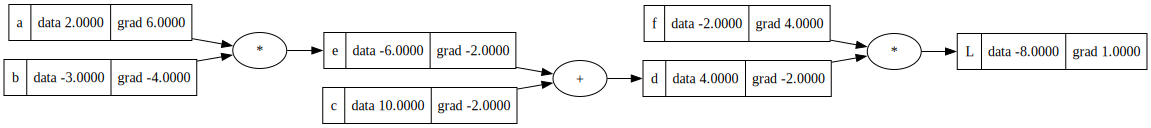

In [22]:
draw_dot(L)

### Move L in the positive direction:

In [23]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f; L.label = 'L'

In [24]:
L.grad = 1.0
f.grad = d.data
d.grad = f.data
c.grad = d.grad
e.grad = d.grad
a.grad = e.grad * b.data
b.grad = e.grad * a.data

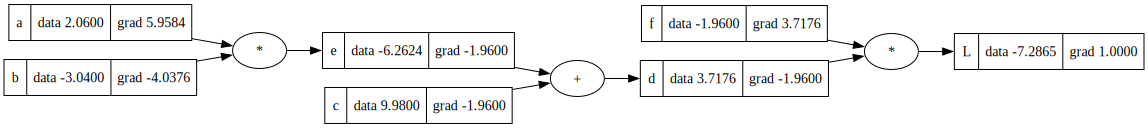

In [25]:
draw_dot(L)

### Building a Single Neuron

In [26]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b')

# Neuron
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# Output of the neuron
o = n.tanh(); o.label = 'o'

In [27]:
o.grad = 1.0

In [28]:
# do / dn = 1 - tanh(n)^2 = 1 - o^2

n.grad = 1 - o.data ** 2

In [29]:
b.grad = n.grad
x1w1x2w2.grad = n.grad

In [30]:
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

In [31]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

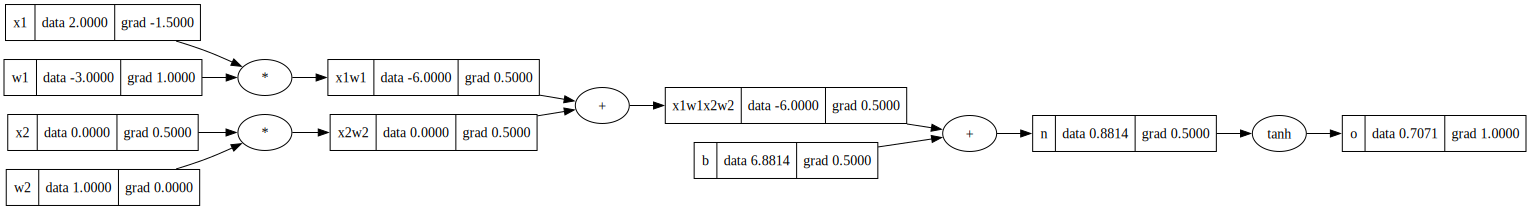

In [32]:
draw_dot(o)

#### Auto Backpropagation

In [33]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b')

# Neuron
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# Output of the neuron
o = n.tanh(); o.label = 'o'

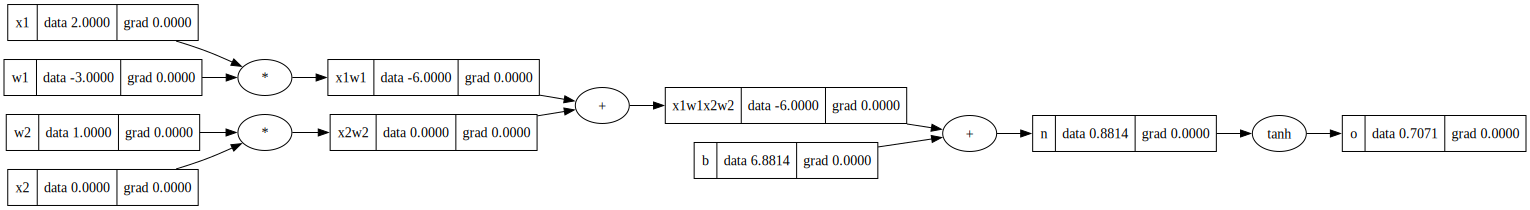

In [34]:
draw_dot(o)

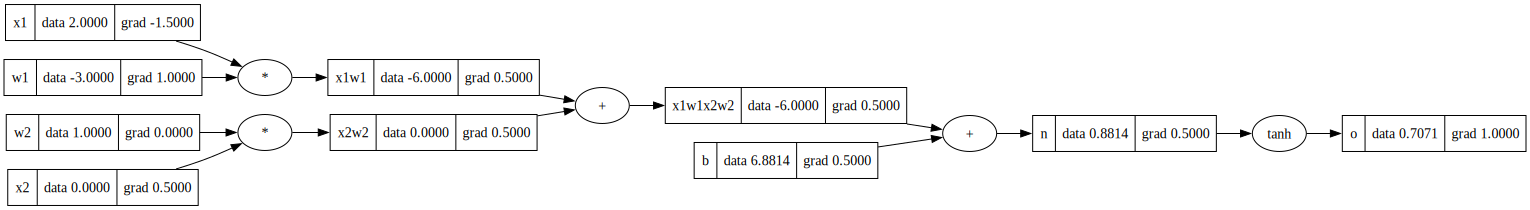

In [35]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

In [36]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b')

# Neuron
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# Output of the neuron
o = n.tanh(); o.label = 'o'

In [37]:
o.backward()

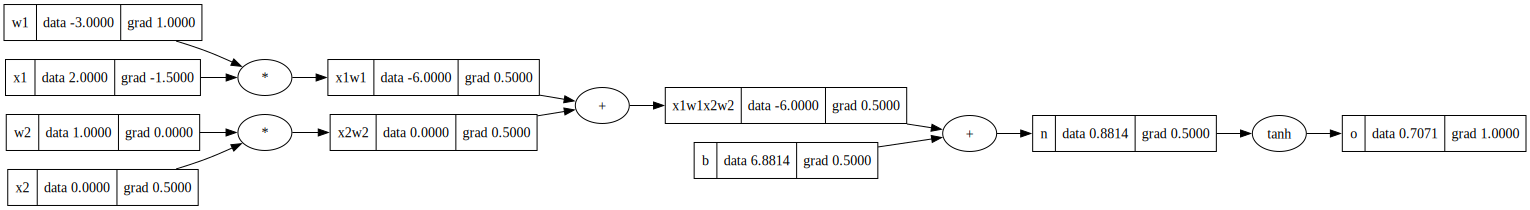

In [38]:
draw_dot(o)

### Multivariate Example

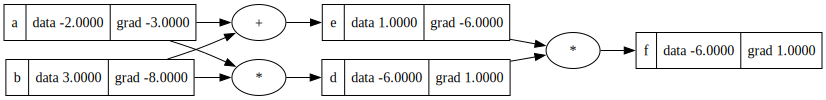

In [39]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

# Breaking down tanh

In [40]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b')

# Neuron
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# Output of the neuron
e = (2*n).exp() 
o = (e - 1) / (e + 1); o.label = 'o'

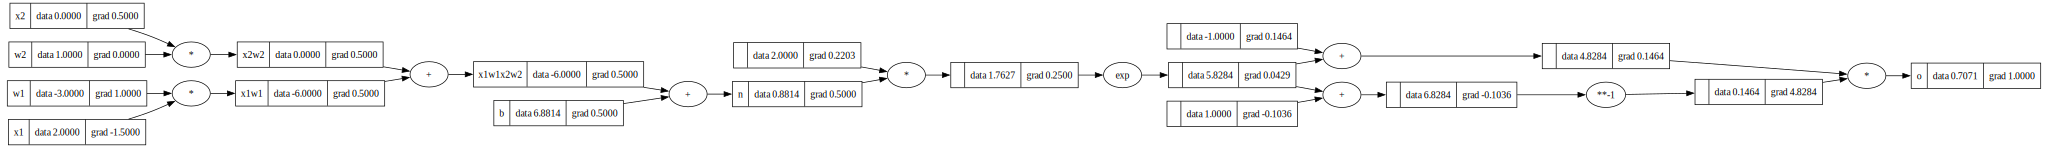

In [41]:
o.backward()
draw_dot(o)

# Bulding Neural Networks

In [65]:
class Neuron:

    def __init__(self, nin):
        """Randomly initialise weights and bias

        Args:
            nin (int): Number of inputs to the neuron
        """
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))


    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        """Creates a list of neurons in the layer

        Args:
            nin (int): Number of inputs to the layer
            nout (int): Number of neurons in the layer
        """
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
    
class MLP:
    def __init__(self, nin, nouts):
        """_summary_

        Args:
            nin (int): Number of inputs to the network
            nouts (int[]): Number of neurons in each layer
        """
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    


In [340]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.984746760292257)

In [341]:
n.parameters()

[Value(data=-0.14492293805096534),
 Value(data=0.17089089756050457),
 Value(data=-0.4084239604921205),
 Value(data=0.06014971814783654),
 Value(data=0.8781233560310051),
 Value(data=0.8201876909766908),
 Value(data=-0.1383312372697838),
 Value(data=-0.06547711071825368),
 Value(data=0.29753295489764553),
 Value(data=-0.7513054762504789),
 Value(data=-0.08984597979498088),
 Value(data=0.22993174565013352),
 Value(data=0.2603537957526181),
 Value(data=-0.1366514333060198),
 Value(data=0.6087863310153623),
 Value(data=0.6053862664863174),
 Value(data=0.7873744195437145),
 Value(data=0.6147606899872229),
 Value(data=-0.6906480599684051),
 Value(data=-0.8944521090992616),
 Value(data=0.03897054351742857),
 Value(data=0.42347764995461246),
 Value(data=-0.0034005043071041463),
 Value(data=-0.612236074487307),
 Value(data=0.10367613638182727),
 Value(data=0.5838037792088417),
 Value(data=-0.2989032251886403),
 Value(data=-0.2469184182590356),
 Value(data=0.9283652592040579),
 Value(data=-0.766

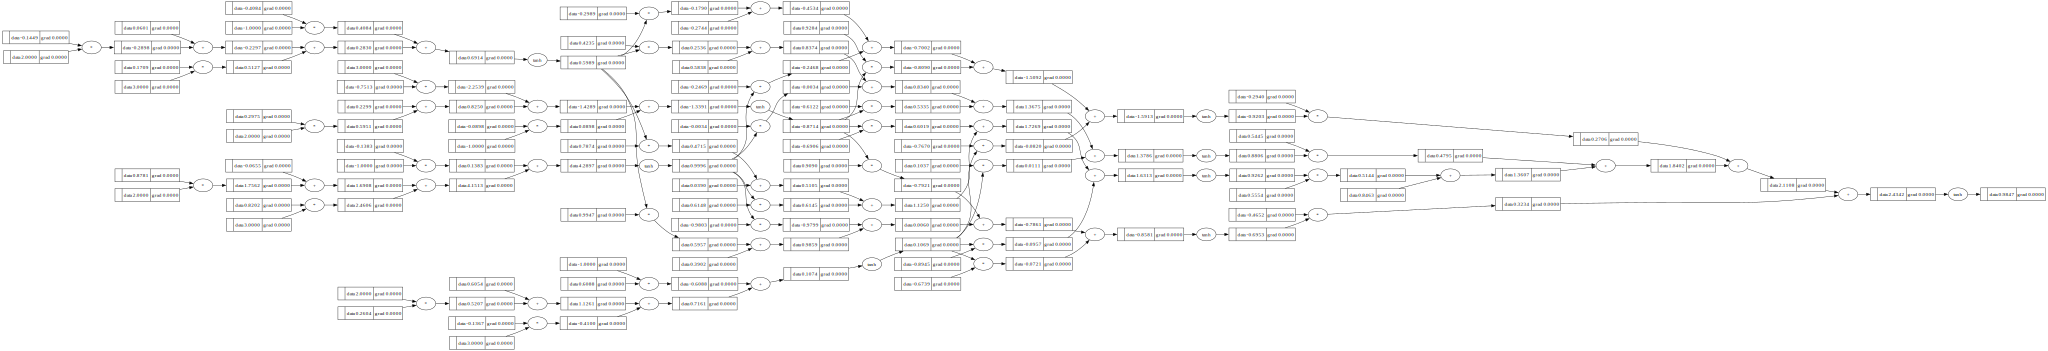

In [342]:
draw_dot(n(x))

In [343]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.984746760292257),
 Value(data=0.5720430901011333),
 Value(data=0.950714955163772),
 Value(data=0.9621716451123611)]

In [344]:
# ygt = y-ground truth
# yout = y-output

loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=6.2782719591894045)

In [345]:
loss.backward()

In [346]:
n.layers[0].neurons[0].w[0].grad

0.8095300394744006

In [347]:
n.layers[0].neurons[0].w[0].data

-0.14492293805096534

In [348]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [349]:
n.layers[0].neurons[0].w[0].data

-0.15301823844570936

In [356]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9383946617270841),
 Value(data=-0.8081565199816214),
 Value(data=-0.0846658463649317),
 Value(data=0.7723545130662327)]

In [357]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.9302582190614214)

In [358]:
for p in n.parameters():
    p.data += -0.01 * p.grad